In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b10','b25','b50','b75'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_0_0_1_0_e_e_0_1_0_basal_seg_data_norm_b10_b25_b50_b75_roi_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_t1_0_42_n_native_08_0_05_n


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(884582, 1132)
(884582, 3)
validation
(154411, 1132)
(154411, 3)
test
(115112, 1132)
(115112, 3)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1132)]            0         


 dense (Dense)               (None, 2048)              2320384   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 3)                 387       


Total params: 5107971 (19.49 MB)


Trainable params: 5107971 (19.49 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


1/9 [==>...........................] - ETA: 1:23 - loss: 1.4448 - STD: 0.2030 - MAE: 0.4740

2/9 [=====>........................] - ETA: 3s - loss: 1.2830 - STD: 0.1381 - MAE: 0.4590  

3/9 [=========>....................] - ETA: 2s - loss: 1.2186 - STD: 0.1311 - MAE: 0.4487

4/9 [============>.................] - ETA: 2s - loss: 1.1967 - STD: 0.1419 - MAE: 0.4412

5/9 [===============>..............] - ETA: 9s - loss: 1.1912 - STD: 0.1533 - MAE: 0.4364

6/9 [===================>..........] - ETA: 6s - loss: 1.1851 - STD: 0.1598 - MAE: 0.4333

7/9 [======================>.......] - ETA: 3s - loss: 1.1766 - STD: 0.1612 - MAE: 0.4314

8/9 [=========================>....] - ETA: 1s - loss: 1.1667 - STD: 0.1586 - MAE: 0.4304

9/9 [==============================] - ETA: 0s - loss: 1.1572 - STD: 0.1533 - MAE: 0.4301

9/9 [==============================] - 25s 2s/step - loss: 1.1572 - STD: 0.1533 - MAE: 0.4301 - val_loss: 1.0761 - val_STD: 0.0831 - val_MAE: 0.4328


Epoch 2/10000


1/9 [==>...........................] - ETA: 7s - loss: 1.0769 - STD: 0.0831 - MAE: 0.4329

2/9 [=====>........................] - ETA: 3s - loss: 1.0781 - STD: 0.0693 - MAE: 0.4351

3/9 [=========>....................] - ETA: 2s - loss: 1.0807 - STD: 0.0560 - MAE: 0.4370

4/9 [============>.................] - ETA: 2s - loss: 1.0841 - STD: 0.0445 - MAE: 0.4386

5/9 [===============>..............] - ETA: 1s - loss: 1.0871 - STD: 0.0358 - MAE: 0.4398

6/9 [===================>..........] - ETA: 1s - loss: 1.0887 - STD: 0.0304 - MAE: 0.4405

7/9 [======================>.......] - ETA: 0s - loss: 1.0889 - STD: 0.0280 - MAE: 0.4408

8/9 [=========================>....] - ETA: 0s - loss: 1.0880 - STD: 0.0284 - MAE: 0.4407

9/9 [==============================] - ETA: 0s - loss: 1.0866 - STD: 0.0308 - MAE: 0.4403

9/9 [==============================] - 5s 523ms/step - loss: 1.0866 - STD: 0.0308 - MAE: 0.4403 - val_loss: 1.0734 - val_STD: 0.0684 - val_MAE: 0.4345


Epoch 3/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0740 - STD: 0.0684 - MAE: 0.4345

2/9 [=====>........................] - ETA: 2s - loss: 1.0740 - STD: 0.0764 - MAE: 0.4333

3/9 [=========>....................] - ETA: 2s - loss: 1.0753 - STD: 0.0832 - MAE: 0.4323

4/9 [============>.................] - ETA: 2s - loss: 1.0762 - STD: 0.0889 - MAE: 0.4314

5/9 [===============>..............] - ETA: 1s - loss: 1.0775 - STD: 0.0934 - MAE: 0.4308

6/9 [===================>..........] - ETA: 1s - loss: 1.0784 - STD: 0.0967 - MAE: 0.4303

7/9 [======================>.......] - ETA: 0s - loss: 1.0787 - STD: 0.0988 - MAE: 0.4300

8/9 [=========================>....] - ETA: 0s - loss: 1.0787 - STD: 0.0997 - MAE: 0.4299

9/9 [==============================] - ETA: 0s - loss: 1.0785 - STD: 0.0995 - MAE: 0.4299

9/9 [==============================] - 5s 516ms/step - loss: 1.0785 - STD: 0.0995 - MAE: 0.4299 - val_loss: 1.0743 - val_STD: 0.0885 - val_MAE: 0.4315


Epoch 4/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0739 - STD: 0.0885 - MAE: 0.4313

2/9 [=====>........................] - ETA: 3s - loss: 1.0737 - STD: 0.0834 - MAE: 0.4321

3/9 [=========>....................] - ETA: 2s - loss: 1.0738 - STD: 0.0785 - MAE: 0.4329

4/9 [============>.................] - ETA: 2s - loss: 1.0737 - STD: 0.0739 - MAE: 0.4336

5/9 [===============>..............] - ETA: 1s - loss: 1.0741 - STD: 0.0701 - MAE: 0.4342

6/9 [===================>..........] - ETA: 1s - loss: 1.0745 - STD: 0.0669 - MAE: 0.4347

7/9 [======================>.......] - ETA: 0s - loss: 1.0748 - STD: 0.0644 - MAE: 0.4350

8/9 [=========================>....] - ETA: 0s - loss: 1.0750 - STD: 0.0627 - MAE: 0.4353

9/9 [==============================] - ETA: 0s - loss: 1.0751 - STD: 0.0617 - MAE: 0.4354

9/9 [==============================] - 5s 522ms/step - loss: 1.0751 - STD: 0.0617 - MAE: 0.4354 - val_loss: 1.0742 - val_STD: 0.0587 - val_MAE: 0.4358


Epoch 5/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0744 - STD: 0.0587 - MAE: 0.4358

2/9 [=====>........................] - ETA: 3s - loss: 1.0744 - STD: 0.0617 - MAE: 0.4354

3/9 [=========>....................] - ETA: 2s - loss: 1.0743 - STD: 0.0649 - MAE: 0.4350

4/9 [============>.................] - ETA: 2s - loss: 1.0739 - STD: 0.0679 - MAE: 0.4345

5/9 [===============>..............] - ETA: 1s - loss: 1.0737 - STD: 0.0707 - MAE: 0.4340

6/9 [===================>..........] - ETA: 1s - loss: 1.0737 - STD: 0.0732 - MAE: 0.4337

7/9 [======================>.......] - ETA: 0s - loss: 1.0739 - STD: 0.0752 - MAE: 0.4334

8/9 [=========================>....] - ETA: 0s - loss: 1.0739 - STD: 0.0768 - MAE: 0.4331

9/9 [==============================] - ETA: 0s - loss: 1.0741 - STD: 0.0779 - MAE: 0.4330

9/9 [==============================] - 5s 517ms/step - loss: 1.0741 - STD: 0.0779 - MAE: 0.4330 - val_loss: 1.0735 - val_STD: 0.0842 - val_MAE: 0.4320


Epoch 6/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0736 - STD: 0.0842 - MAE: 0.4320

2/9 [=====>........................] - ETA: 3s - loss: 1.0743 - STD: 0.0824 - MAE: 0.4324

3/9 [=========>....................] - ETA: 2s - loss: 1.0741 - STD: 0.0805 - MAE: 0.4327

4/9 [============>.................] - ETA: 2s - loss: 1.0737 - STD: 0.0784 - MAE: 0.4329

5/9 [===============>..............] - ETA: 1s - loss: 1.0738 - STD: 0.0764 - MAE: 0.4332

6/9 [===================>..........] - ETA: 1s - loss: 1.0739 - STD: 0.0746 - MAE: 0.4335

7/9 [======================>.......] - ETA: 0s - loss: 1.0737 - STD: 0.0730 - MAE: 0.4337

8/9 [=========================>....] - ETA: 0s - loss: 1.0736 - STD: 0.0718 - MAE: 0.4339

9/9 [==============================] - ETA: 0s - loss: 1.0736 - STD: 0.0709 - MAE: 0.4340

9/9 [==============================] - 5s 523ms/step - loss: 1.0736 - STD: 0.0709 - MAE: 0.4340 - val_loss: 1.0729 - val_STD: 0.0660 - val_MAE: 0.4346


Epoch 7/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0743 - STD: 0.0660 - MAE: 0.4349

2/9 [=====>........................] - ETA: 3s - loss: 1.0734 - STD: 0.0672 - MAE: 0.4345

3/9 [=========>....................] - ETA: 2s - loss: 1.0730 - STD: 0.0685 - MAE: 0.4342

4/9 [============>.................] - ETA: 2s - loss: 1.0729 - STD: 0.0699 - MAE: 0.4340

5/9 [===============>..............] - ETA: 1s - loss: 1.0731 - STD: 0.0712 - MAE: 0.4339

6/9 [===================>..........] - ETA: 1s - loss: 1.0729 - STD: 0.0724 - MAE: 0.4337

7/9 [======================>.......] - ETA: 0s - loss: 1.0729 - STD: 0.0734 - MAE: 0.4335

8/9 [=========================>....] - ETA: 0s - loss: 1.0728 - STD: 0.0742 - MAE: 0.4334

9/9 [==============================] - ETA: 0s - loss: 1.0727 - STD: 0.0747 - MAE: 0.4333

9/9 [==============================] - 5s 546ms/step - loss: 1.0727 - STD: 0.0747 - MAE: 0.4333 - val_loss: 1.0714 - val_STD: 0.0777 - val_MAE: 0.4326


Epoch 8/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0724 - STD: 0.0777 - MAE: 0.4327

2/9 [=====>........................] - ETA: 3s - loss: 1.0722 - STD: 0.0768 - MAE: 0.4328

3/9 [=========>....................] - ETA: 2s - loss: 1.0716 - STD: 0.0759 - MAE: 0.4328

4/9 [============>.................] - ETA: 2s - loss: 1.0714 - STD: 0.0749 - MAE: 0.4329

5/9 [===============>..............] - ETA: 1s - loss: 1.0708 - STD: 0.0740 - MAE: 0.4329

6/9 [===================>..........] - ETA: 1s - loss: 1.0707 - STD: 0.0733 - MAE: 0.4330

7/9 [======================>.......] - ETA: 0s - loss: 1.0703 - STD: 0.0727 - MAE: 0.4330

8/9 [=========================>....] - ETA: 0s - loss: 1.0699 - STD: 0.0723 - MAE: 0.4329

9/9 [==============================] - ETA: 0s - loss: 1.0694 - STD: 0.0721 - MAE: 0.4328

9/9 [==============================] - 5s 524ms/step - loss: 1.0694 - STD: 0.0721 - MAE: 0.4328 - val_loss: 1.0640 - val_STD: 0.0711 - val_MAE: 0.4317


Epoch 9/10000


1/9 [==>...........................] - ETA: 6s - loss: 1.0650 - STD: 0.0711 - MAE: 0.4318

2/9 [=====>........................] - ETA: 3s - loss: 1.0634 - STD: 0.0717 - MAE: 0.4314

3/9 [=========>....................] - ETA: 2s - loss: 1.0616 - STD: 0.0722 - MAE: 0.4309

4/9 [============>.................] - ETA: 2s - loss: 1.0603 - STD: 0.0728 - MAE: 0.4305

5/9 [===============>..............] - ETA: 1s - loss: 1.0588 - STD: 0.0733 - MAE: 0.4300

6/9 [===================>..........] - ETA: 1s - loss: 1.0569 - STD: 0.0738 - MAE: 0.4294

7/9 [======================>.......] - ETA: 0s - loss: 1.0548 - STD: 0.0743 - MAE: 0.4288

8/9 [=========================>....] - ETA: 0s - loss: 1.0525 - STD: 0.0747 - MAE: 0.4282

9/9 [==============================] - ETA: 0s - loss: 1.0499 - STD: 0.0751 - MAE: 0.4274

9/9 [==============================] - 5s 535ms/step - loss: 1.0499 - STD: 0.0751 - MAE: 0.4274 - val_loss: 1.0211 - val_STD: 0.0806 - val_MAE: 0.4194


Epoch 10/10000


1/9 [==>...........................] - ETA: 5s - loss: 1.0206 - STD: 0.0807 - MAE: 0.4192

2/9 [=====>........................] - ETA: 3s - loss: 1.0139 - STD: 0.0812 - MAE: 0.4174

3/9 [=========>....................] - ETA: 2s - loss: 1.0078 - STD: 0.0827 - MAE: 0.4155

4/9 [============>.................] - ETA: 2s - loss: 1.0015 - STD: 0.0853 - MAE: 0.4137

5/9 [===============>..............] - ETA: 1s - loss: 0.9940 - STD: 0.0881 - MAE: 0.4112

6/9 [===================>..........] - ETA: 1s - loss: 0.9861 - STD: 0.0919 - MAE: 0.4084

7/9 [======================>.......] - ETA: 0s - loss: 0.9787 - STD: 0.0967 - MAE: 0.4057

8/9 [=========================>....] - ETA: 0s - loss: 0.9703 - STD: 0.1021 - MAE: 0.4023

9/9 [==============================] - ETA: 0s - loss: 0.9615 - STD: 0.1081 - MAE: 0.3987

9/9 [==============================] - 5s 532ms/step - loss: 0.9615 - STD: 0.1081 - MAE: 0.3987 - val_loss: 0.8899 - val_STD: 0.1753 - val_MAE: 0.3632


Epoch 11/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.8717 - STD: 0.1732 - MAE: 0.3595

2/9 [=====>........................] - ETA: 3s - loss: 0.8645 - STD: 0.1819 - MAE: 0.3550

3/9 [=========>....................] - ETA: 2s - loss: 0.8571 - STD: 0.1902 - MAE: 0.3504

4/9 [============>.................] - ETA: 2s - loss: 0.8553 - STD: 0.1980 - MAE: 0.3472

5/9 [===============>..............] - ETA: 1s - loss: 0.8707 - STD: 0.2062 - MAE: 0.3465

6/9 [===================>..........] - ETA: 1s - loss: 0.8657 - STD: 0.2119 - MAE: 0.3430

7/9 [======================>.......] - ETA: 0s - loss: 0.8850 - STD: 0.2197 - MAE: 0.3441

8/9 [=========================>....] - ETA: 0s - loss: 0.8745 - STD: 0.2227 - MAE: 0.3408

9/9 [==============================] - ETA: 0s - loss: 0.8782 - STD: 0.2261 - MAE: 0.3397

9/9 [==============================] - 5s 547ms/step - loss: 0.8782 - STD: 0.2261 - MAE: 0.3397 - val_loss: 0.8637 - val_STD: 0.2464 - val_MAE: 0.3271


Epoch 12/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.8574 - STD: 0.2478 - MAE: 0.3252

2/9 [=====>........................] - ETA: 3s - loss: 0.8190 - STD: 0.2400 - MAE: 0.3224

3/9 [=========>....................] - ETA: 2s - loss: 0.8412 - STD: 0.2401 - MAE: 0.3283

4/9 [============>.................] - ETA: 2s - loss: 0.8248 - STD: 0.2369 - MAE: 0.3264

5/9 [===============>..............] - ETA: 1s - loss: 0.8237 - STD: 0.2383 - MAE: 0.3253

6/9 [===================>..........] - ETA: 1s - loss: 0.8250 - STD: 0.2399 - MAE: 0.3247

7/9 [======================>.......] - ETA: 0s - loss: 0.8176 - STD: 0.2389 - MAE: 0.3237

8/9 [=========================>....] - ETA: 0s - loss: 0.8151 - STD: 0.2369 - MAE: 0.3242

9/9 [==============================] - ETA: 0s - loss: 0.8130 - STD: 0.2356 - MAE: 0.3245

9/9 [==============================] - 5s 533ms/step - loss: 0.8130 - STD: 0.2356 - MAE: 0.3245 - val_loss: 0.7780 - val_STD: 0.2378 - val_MAE: 0.3164


Epoch 13/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.7573 - STD: 0.2372 - MAE: 0.3119

2/9 [=====>........................] - ETA: 2s - loss: 0.7738 - STD: 0.2469 - MAE: 0.3112

3/9 [=========>....................] - ETA: 2s - loss: 0.7756 - STD: 0.2494 - MAE: 0.3104

4/9 [============>.................] - ETA: 2s - loss: 0.7685 - STD: 0.2461 - MAE: 0.3105

5/9 [===============>..............] - ETA: 1s - loss: 0.7707 - STD: 0.2431 - MAE: 0.3125

6/9 [===================>..........] - ETA: 1s - loss: 0.7658 - STD: 0.2422 - MAE: 0.3119

7/9 [======================>.......] - ETA: 0s - loss: 0.7640 - STD: 0.2446 - MAE: 0.3104

8/9 [=========================>....] - ETA: 0s - loss: 0.7631 - STD: 0.2473 - MAE: 0.3089

9/9 [==============================] - ETA: 0s - loss: 0.7597 - STD: 0.2476 - MAE: 0.3081

9/9 [==============================] - 5s 516ms/step - loss: 0.7597 - STD: 0.2476 - MAE: 0.3081 - val_loss: 0.8122 - val_STD: 0.2413 - val_MAE: 0.3210


Epoch 14/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.7521 - STD: 0.2385 - MAE: 0.3109

2/9 [=====>........................] - ETA: 3s - loss: 0.7429 - STD: 0.2419 - MAE: 0.3074

3/9 [=========>....................] - ETA: 2s - loss: 0.7412 - STD: 0.2500 - MAE: 0.3032

4/9 [============>.................] - ETA: 2s - loss: 0.7400 - STD: 0.2553 - MAE: 0.3004

5/9 [===============>..............] - ETA: 1s - loss: 0.7363 - STD: 0.2556 - MAE: 0.2995

6/9 [===================>..........] - ETA: 1s - loss: 0.7365 - STD: 0.2543 - MAE: 0.3002

7/9 [======================>.......] - ETA: 0s - loss: 0.7342 - STD: 0.2545 - MAE: 0.2996

8/9 [=========================>....] - ETA: 0s - loss: 0.7332 - STD: 0.2566 - MAE: 0.2983

9/9 [==============================] - ETA: 0s - loss: 0.7310 - STD: 0.2580 - MAE: 0.2972

9/9 [==============================] - 5s 546ms/step - loss: 0.7310 - STD: 0.2580 - MAE: 0.2972 - val_loss: 0.7581 - val_STD: 0.2575 - val_MAE: 0.3031


Epoch 15/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.7121 - STD: 0.2574 - MAE: 0.2939

2/9 [=====>........................] - ETA: 3s - loss: 0.7133 - STD: 0.2577 - MAE: 0.2940

3/9 [=========>....................] - ETA: 2s - loss: 0.7123 - STD: 0.2617 - MAE: 0.2917

4/9 [============>.................] - ETA: 2s - loss: 0.7117 - STD: 0.2653 - MAE: 0.2897

5/9 [===============>..............] - ETA: 1s - loss: 0.7106 - STD: 0.2658 - MAE: 0.2892

6/9 [===================>..........] - ETA: 1s - loss: 0.7097 - STD: 0.2657 - MAE: 0.2891

7/9 [======================>.......] - ETA: 0s - loss: 0.7075 - STD: 0.2666 - MAE: 0.2882

8/9 [=========================>....] - ETA: 0s - loss: 0.7063 - STD: 0.2681 - MAE: 0.2871

9/9 [==============================] - ETA: 0s - loss: 0.7051 - STD: 0.2685 - MAE: 0.2867

9/9 [==============================] - 5s 542ms/step - loss: 0.7051 - STD: 0.2685 - MAE: 0.2867 - val_loss: 0.7426 - val_STD: 0.2683 - val_MAE: 0.2944


Epoch 16/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6960 - STD: 0.2690 - MAE: 0.2846

2/9 [=====>........................] - ETA: 3s - loss: 0.6949 - STD: 0.2721 - MAE: 0.2827

3/9 [=========>....................] - ETA: 2s - loss: 0.6947 - STD: 0.2751 - MAE: 0.2810

4/9 [============>.................] - ETA: 2s - loss: 0.6926 - STD: 0.2752 - MAE: 0.2806

5/9 [===============>..............] - ETA: 1s - loss: 0.6918 - STD: 0.2751 - MAE: 0.2805

6/9 [===================>..........] - ETA: 1s - loss: 0.6908 - STD: 0.2763 - MAE: 0.2797

7/9 [======================>.......] - ETA: 0s - loss: 0.6900 - STD: 0.2773 - MAE: 0.2789

8/9 [=========================>....] - ETA: 0s - loss: 0.6894 - STD: 0.2774 - MAE: 0.2788

9/9 [==============================] - ETA: 0s - loss: 0.6885 - STD: 0.2777 - MAE: 0.2785

9/9 [==============================] - 5s 548ms/step - loss: 0.6885 - STD: 0.2777 - MAE: 0.2785 - val_loss: 0.7067 - val_STD: 0.2812 - val_MAE: 0.2805


Epoch 17/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.6836 - STD: 0.2840 - MAE: 0.2739

2/9 [=====>........................] - ETA: 3s - loss: 0.6805 - STD: 0.2827 - MAE: 0.2742

3/9 [=========>....................] - ETA: 2s - loss: 0.6782 - STD: 0.2822 - MAE: 0.2740

4/9 [============>.................] - ETA: 2s - loss: 0.6775 - STD: 0.2838 - MAE: 0.2730

5/9 [===============>..............] - ETA: 1s - loss: 0.6758 - STD: 0.2847 - MAE: 0.2722

6/9 [===================>..........] - ETA: 1s - loss: 0.6755 - STD: 0.2847 - MAE: 0.2722

7/9 [======================>.......] - ETA: 0s - loss: 0.6748 - STD: 0.2854 - MAE: 0.2716

8/9 [=========================>....] - ETA: 0s - loss: 0.6736 - STD: 0.2854 - MAE: 0.2714

9/9 [==============================] - ETA: 0s - loss: 0.6730 - STD: 0.2852 - MAE: 0.2714

9/9 [==============================] - 5s 550ms/step - loss: 0.6730 - STD: 0.2852 - MAE: 0.2714 - val_loss: 0.6859 - val_STD: 0.2873 - val_MAE: 0.2731


Epoch 18/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6622 - STD: 0.2914 - MAE: 0.2654

2/9 [=====>........................] - ETA: 3s - loss: 0.6600 - STD: 0.2914 - MAE: 0.2652

3/9 [=========>....................] - ETA: 2s - loss: 0.6591 - STD: 0.2911 - MAE: 0.2653

4/9 [============>.................] - ETA: 2s - loss: 0.6599 - STD: 0.2923 - MAE: 0.2646

5/9 [===============>..............] - ETA: 1s - loss: 0.6594 - STD: 0.2918 - MAE: 0.2649

6/9 [===================>..........] - ETA: 1s - loss: 0.6581 - STD: 0.2914 - MAE: 0.2649

7/9 [======================>.......] - ETA: 0s - loss: 0.6574 - STD: 0.2916 - MAE: 0.2646

8/9 [=========================>....] - ETA: 0s - loss: 0.6570 - STD: 0.2916 - MAE: 0.2646

9/9 [==============================] - ETA: 0s - loss: 0.6570 - STD: 0.2924 - MAE: 0.2640

9/9 [==============================] - 5s 542ms/step - loss: 0.6570 - STD: 0.2924 - MAE: 0.2640 - val_loss: 0.7004 - val_STD: 0.2967 - val_MAE: 0.2712


Epoch 19/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.6473 - STD: 0.2966 - MAE: 0.2603

2/9 [=====>........................] - ETA: 3s - loss: 0.6421 - STD: 0.2969 - MAE: 0.2587

3/9 [=========>....................] - ETA: 2s - loss: 0.6415 - STD: 0.2962 - MAE: 0.2588

4/9 [============>.................] - ETA: 2s - loss: 0.6412 - STD: 0.2958 - MAE: 0.2590

5/9 [===============>..............] - ETA: 1s - loss: 0.6432 - STD: 0.2964 - MAE: 0.2588

6/9 [===================>..........] - ETA: 1s - loss: 0.6448 - STD: 0.2971 - MAE: 0.2589

7/9 [======================>.......] - ETA: 0s - loss: 0.6470 - STD: 0.2983 - MAE: 0.2584

8/9 [=========================>....] - ETA: 0s - loss: 0.6469 - STD: 0.2987 - MAE: 0.2583

9/9 [==============================] - ETA: 0s - loss: 0.6452 - STD: 0.2991 - MAE: 0.2576

9/9 [==============================] - 5s 533ms/step - loss: 0.6452 - STD: 0.2991 - MAE: 0.2576 - val_loss: 0.6491 - val_STD: 0.3008 - val_MAE: 0.2584


Epoch 20/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.6280 - STD: 0.3005 - MAE: 0.2530

2/9 [=====>........................] - ETA: 3s - loss: 0.6319 - STD: 0.3011 - MAE: 0.2541

3/9 [=========>....................] - ETA: 2s - loss: 0.6389 - STD: 0.3020 - MAE: 0.2544

4/9 [============>.................] - ETA: 2s - loss: 0.6381 - STD: 0.3025 - MAE: 0.2543

5/9 [===============>..............] - ETA: 1s - loss: 0.6347 - STD: 0.3033 - MAE: 0.2530

6/9 [===================>..........] - ETA: 1s - loss: 0.6320 - STD: 0.3038 - MAE: 0.2521

7/9 [======================>.......] - ETA: 0s - loss: 0.6313 - STD: 0.3043 - MAE: 0.2518

8/9 [=========================>....] - ETA: 0s - loss: 0.6308 - STD: 0.3044 - MAE: 0.2515

9/9 [==============================] - ETA: 0s - loss: 0.6297 - STD: 0.3045 - MAE: 0.2512

9/9 [==============================] - 5s 519ms/step - loss: 0.6297 - STD: 0.3045 - MAE: 0.2512 - val_loss: 0.6505 - val_STD: 0.3086 - val_MAE: 0.2545


Epoch 21/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6106 - STD: 0.3069 - MAE: 0.2459

2/9 [=====>........................] - ETA: 3s - loss: 0.6106 - STD: 0.3080 - MAE: 0.2450

3/9 [=========>....................] - ETA: 2s - loss: 0.6112 - STD: 0.3096 - MAE: 0.2445

4/9 [============>.................] - ETA: 2s - loss: 0.6125 - STD: 0.3098 - MAE: 0.2445

5/9 [===============>..............] - ETA: 1s - loss: 0.6114 - STD: 0.3098 - MAE: 0.2443

6/9 [===================>..........] - ETA: 1s - loss: 0.6102 - STD: 0.3097 - MAE: 0.2440

7/9 [======================>.......] - ETA: 0s - loss: 0.6090 - STD: 0.3101 - MAE: 0.2436

8/9 [=========================>....] - ETA: 0s - loss: 0.6087 - STD: 0.3105 - MAE: 0.2433

9/9 [==============================] - ETA: 0s - loss: 0.6080 - STD: 0.3109 - MAE: 0.2429

9/9 [==============================] - 5s 547ms/step - loss: 0.6080 - STD: 0.3109 - MAE: 0.2429 - val_loss: 0.6287 - val_STD: 0.3145 - val_MAE: 0.2465


Epoch 22/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5988 - STD: 0.3130 - MAE: 0.2396

2/9 [=====>........................] - ETA: 3s - loss: 0.5981 - STD: 0.3133 - MAE: 0.2394

3/9 [=========>....................] - ETA: 2s - loss: 0.5985 - STD: 0.3132 - MAE: 0.2395

4/9 [============>.................] - ETA: 2s - loss: 0.5979 - STD: 0.3144 - MAE: 0.2387

5/9 [===============>..............] - ETA: 1s - loss: 0.5993 - STD: 0.3146 - MAE: 0.2387

6/9 [===================>..........] - ETA: 1s - loss: 0.6040 - STD: 0.3159 - MAE: 0.2390

7/9 [======================>.......] - ETA: 0s - loss: 0.6207 - STD: 0.3149 - MAE: 0.2429

8/9 [=========================>....] - ETA: 0s - loss: 0.6255 - STD: 0.3154 - MAE: 0.2438

9/9 [==============================] - ETA: 0s - loss: 0.6227 - STD: 0.3151 - MAE: 0.2434

9/9 [==============================] - 5s 522ms/step - loss: 0.6227 - STD: 0.3151 - MAE: 0.2434 - val_loss: 0.6061 - val_STD: 0.3152 - val_MAE: 0.2403


Epoch 23/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.6061 - STD: 0.3170 - MAE: 0.2379

2/9 [=====>........................] - ETA: 3s - loss: 0.6138 - STD: 0.3206 - MAE: 0.2382

3/9 [=========>....................] - ETA: 2s - loss: 0.6065 - STD: 0.3213 - MAE: 0.2361

4/9 [============>.................] - ETA: 2s - loss: 0.6062 - STD: 0.3206 - MAE: 0.2363

5/9 [===============>..............] - ETA: 1s - loss: 0.6056 - STD: 0.3196 - MAE: 0.2370

6/9 [===================>..........] - ETA: 1s - loss: 0.6028 - STD: 0.3188 - MAE: 0.2370

7/9 [======================>.......] - ETA: 0s - loss: 0.6013 - STD: 0.3188 - MAE: 0.2366

8/9 [=========================>....] - ETA: 0s - loss: 0.5996 - STD: 0.3194 - MAE: 0.2360

9/9 [==============================] - ETA: 0s - loss: 0.5986 - STD: 0.3197 - MAE: 0.2356

9/9 [==============================] - 5s 533ms/step - loss: 0.5986 - STD: 0.3197 - MAE: 0.2356 - val_loss: 0.6021 - val_STD: 0.3173 - val_MAE: 0.2390


Epoch 24/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.5902 - STD: 0.3175 - MAE: 0.2350

2/9 [=====>........................] - ETA: 3s - loss: 0.5822 - STD: 0.3180 - MAE: 0.2334

3/9 [=========>....................] - ETA: 2s - loss: 0.5851 - STD: 0.3189 - MAE: 0.2334

4/9 [============>.................] - ETA: 2s - loss: 0.5847 - STD: 0.3195 - MAE: 0.2328

5/9 [===============>..............] - ETA: 1s - loss: 0.5834 - STD: 0.3209 - MAE: 0.2317

6/9 [===================>..........] - ETA: 1s - loss: 0.5823 - STD: 0.3220 - MAE: 0.2308

7/9 [======================>.......] - ETA: 0s - loss: 0.5828 - STD: 0.3219 - MAE: 0.2309

8/9 [=========================>....] - ETA: 0s - loss: 0.5815 - STD: 0.3224 - MAE: 0.2303

9/9 [==============================] - ETA: 0s - loss: 0.5801 - STD: 0.3228 - MAE: 0.2297

9/9 [==============================] - 5s 537ms/step - loss: 0.5801 - STD: 0.3228 - MAE: 0.2297 - val_loss: 0.5900 - val_STD: 0.3280 - val_MAE: 0.2294


Epoch 25/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5737 - STD: 0.3272 - MAE: 0.2252

2/9 [=====>........................] - ETA: 3s - loss: 0.5723 - STD: 0.3276 - MAE: 0.2249

3/9 [=========>....................] - ETA: 2s - loss: 0.5706 - STD: 0.3261 - MAE: 0.2254

4/9 [============>.................] - ETA: 2s - loss: 0.5700 - STD: 0.3261 - MAE: 0.2253

5/9 [===============>..............] - ETA: 1s - loss: 0.5685 - STD: 0.3264 - MAE: 0.2247

6/9 [===================>..........] - ETA: 1s - loss: 0.5674 - STD: 0.3267 - MAE: 0.2243

7/9 [======================>.......] - ETA: 0s - loss: 0.5662 - STD: 0.3270 - MAE: 0.2239

8/9 [=========================>....] - ETA: 0s - loss: 0.5650 - STD: 0.3271 - MAE: 0.2236

9/9 [==============================] - ETA: 0s - loss: 0.5649 - STD: 0.3278 - MAE: 0.2231

9/9 [==============================] - 5s 524ms/step - loss: 0.5649 - STD: 0.3278 - MAE: 0.2231 - val_loss: 0.5681 - val_STD: 0.3262 - val_MAE: 0.2256


Epoch 26/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5710 - STD: 0.3256 - MAE: 0.2257

2/9 [=====>........................] - ETA: 3s - loss: 0.5695 - STD: 0.3301 - MAE: 0.2225

3/9 [=========>....................] - ETA: 2s - loss: 0.5671 - STD: 0.3299 - MAE: 0.2221

4/9 [============>.................] - ETA: 2s - loss: 0.5634 - STD: 0.3314 - MAE: 0.2203

5/9 [===============>..............] - ETA: 1s - loss: 0.5598 - STD: 0.3316 - MAE: 0.2195

6/9 [===================>..........] - ETA: 1s - loss: 0.5579 - STD: 0.3316 - MAE: 0.2191

7/9 [======================>.......] - ETA: 0s - loss: 0.5582 - STD: 0.3325 - MAE: 0.2186

8/9 [=========================>....] - ETA: 0s - loss: 0.5606 - STD: 0.3311 - MAE: 0.2201

9/9 [==============================] - ETA: 0s - loss: 0.5600 - STD: 0.3321 - MAE: 0.2193

9/9 [==============================] - 5s 524ms/step - loss: 0.5600 - STD: 0.3321 - MAE: 0.2193 - val_loss: 0.5686 - val_STD: 0.3359 - val_MAE: 0.2201


Epoch 27/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.5394 - STD: 0.3346 - MAE: 0.2135

2/9 [=====>........................] - ETA: 2s - loss: 0.5389 - STD: 0.3336 - MAE: 0.2140

3/9 [=========>....................] - ETA: 2s - loss: 0.5413 - STD: 0.3361 - MAE: 0.2129

4/9 [============>.................] - ETA: 2s - loss: 0.5465 - STD: 0.3350 - MAE: 0.2147

5/9 [===============>..............] - ETA: 1s - loss: 0.5455 - STD: 0.3359 - MAE: 0.2139

6/9 [===================>..........] - ETA: 1s - loss: 0.5430 - STD: 0.3363 - MAE: 0.2132

7/9 [======================>.......] - ETA: 0s - loss: 0.5422 - STD: 0.3363 - MAE: 0.2130

8/9 [=========================>....] - ETA: 0s - loss: 0.5420 - STD: 0.3370 - MAE: 0.2125

9/9 [==============================] - ETA: 0s - loss: 0.5441 - STD: 0.3361 - MAE: 0.2136

9/9 [==============================] - 5s 543ms/step - loss: 0.5441 - STD: 0.3361 - MAE: 0.2136 - val_loss: 0.6467 - val_STD: 0.3521 - val_MAE: 0.2234


Epoch 28/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.5527 - STD: 0.3479 - MAE: 0.2077

2/9 [=====>........................] - ETA: 3s - loss: 0.5470 - STD: 0.3423 - MAE: 0.2103

3/9 [=========>....................] - ETA: 2s - loss: 0.5411 - STD: 0.3418 - MAE: 0.2094

4/9 [============>.................] - ETA: 2s - loss: 0.5363 - STD: 0.3427 - MAE: 0.2078

5/9 [===============>..............] - ETA: 1s - loss: 0.5374 - STD: 0.3423 - MAE: 0.2083

6/9 [===================>..........] - ETA: 1s - loss: 0.5377 - STD: 0.3428 - MAE: 0.2081

7/9 [======================>.......] - ETA: 0s - loss: 0.5378 - STD: 0.3421 - MAE: 0.2086

8/9 [=========================>....] - ETA: 0s - loss: 0.5357 - STD: 0.3429 - MAE: 0.2076

9/9 [==============================] - ETA: 0s - loss: 0.5339 - STD: 0.3429 - MAE: 0.2073

9/9 [==============================] - 5s 526ms/step - loss: 0.5339 - STD: 0.3429 - MAE: 0.2073 - val_loss: 0.5443 - val_STD: 0.3422 - val_MAE: 0.2114


Epoch 29/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.5301 - STD: 0.3374 - MAE: 0.2104

2/9 [=====>........................] - ETA: 3s - loss: 0.5348 - STD: 0.3431 - MAE: 0.2074

3/9 [=========>....................] - ETA: 2s - loss: 0.5376 - STD: 0.3417 - MAE: 0.2090

4/9 [============>.................] - ETA: 2s - loss: 0.5333 - STD: 0.3425 - MAE: 0.2075

5/9 [===============>..............] - ETA: 1s - loss: 0.5291 - STD: 0.3427 - MAE: 0.2066

6/9 [===================>..........] - ETA: 1s - loss: 0.5262 - STD: 0.3432 - MAE: 0.2057

7/9 [======================>.......] - ETA: 0s - loss: 0.5247 - STD: 0.3439 - MAE: 0.2049

8/9 [=========================>....] - ETA: 0s - loss: 0.5241 - STD: 0.3436 - MAE: 0.2050

9/9 [==============================] - ETA: 0s - loss: 0.5239 - STD: 0.3442 - MAE: 0.2045

9/9 [==============================] - 5s 525ms/step - loss: 0.5239 - STD: 0.3442 - MAE: 0.2045 - val_loss: 0.5349 - val_STD: 0.3485 - val_MAE: 0.2051


Epoch 30/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5187 - STD: 0.3453 - MAE: 0.2029

2/9 [=====>........................] - ETA: 3s - loss: 0.5128 - STD: 0.3452 - MAE: 0.2017

3/9 [=========>....................] - ETA: 2s - loss: 0.5097 - STD: 0.3455 - MAE: 0.2009

4/9 [============>.................] - ETA: 2s - loss: 0.5090 - STD: 0.3458 - MAE: 0.2006

5/9 [===============>..............] - ETA: 1s - loss: 0.5087 - STD: 0.3461 - MAE: 0.2003

6/9 [===================>..........] - ETA: 1s - loss: 0.5099 - STD: 0.3455 - MAE: 0.2010

7/9 [======================>.......] - ETA: 0s - loss: 0.5121 - STD: 0.3466 - MAE: 0.2007

8/9 [=========================>....] - ETA: 0s - loss: 0.5171 - STD: 0.3459 - MAE: 0.2022

9/9 [==============================] - ETA: 0s - loss: 0.5198 - STD: 0.3468 - MAE: 0.2021

9/9 [==============================] - 5s 547ms/step - loss: 0.5198 - STD: 0.3468 - MAE: 0.2021 - val_loss: 0.5270 - val_STD: 0.3503 - val_MAE: 0.2019


Epoch 31/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5340 - STD: 0.3473 - MAE: 0.2046

2/9 [=====>........................] - ETA: 3s - loss: 0.5183 - STD: 0.3497 - MAE: 0.1999

3/9 [=========>....................] - ETA: 2s - loss: 0.5171 - STD: 0.3509 - MAE: 0.1988

4/9 [============>.................] - ETA: 2s - loss: 0.5236 - STD: 0.3494 - MAE: 0.2011

5/9 [===============>..............] - ETA: 1s - loss: 0.5219 - STD: 0.3506 - MAE: 0.2000

6/9 [===================>..........] - ETA: 1s - loss: 0.5178 - STD: 0.3501 - MAE: 0.1995

7/9 [======================>.......] - ETA: 0s - loss: 0.5169 - STD: 0.3491 - MAE: 0.2000

8/9 [=========================>....] - ETA: 0s - loss: 0.5173 - STD: 0.3496 - MAE: 0.1998

9/9 [==============================] - ETA: 0s - loss: 0.5160 - STD: 0.3490 - MAE: 0.1999

9/9 [==============================] - 5s 517ms/step - loss: 0.5160 - STD: 0.3490 - MAE: 0.1999 - val_loss: 0.5386 - val_STD: 0.3473 - val_MAE: 0.2072


Epoch 32/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4930 - STD: 0.3440 - MAE: 0.1989

2/9 [=====>........................] - ETA: 3s - loss: 0.5025 - STD: 0.3469 - MAE: 0.1988

3/9 [=========>....................] - ETA: 2s - loss: 0.5081 - STD: 0.3462 - MAE: 0.2006

4/9 [============>.................] - ETA: 2s - loss: 0.5055 - STD: 0.3466 - MAE: 0.1997

5/9 [===============>..............] - ETA: 1s - loss: 0.5035 - STD: 0.3472 - MAE: 0.1989

6/9 [===================>..........] - ETA: 1s - loss: 0.5042 - STD: 0.3475 - MAE: 0.1988

7/9 [======================>.......] - ETA: 0s - loss: 0.5031 - STD: 0.3484 - MAE: 0.1980

8/9 [=========================>....] - ETA: 0s - loss: 0.5010 - STD: 0.3486 - MAE: 0.1974

9/9 [==============================] - ETA: 0s - loss: 0.4999 - STD: 0.3489 - MAE: 0.1970

9/9 [==============================] - 5s 543ms/step - loss: 0.4999 - STD: 0.3489 - MAE: 0.1970 - val_loss: 0.5630 - val_STD: 0.3567 - val_MAE: 0.2049


Epoch 33/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4898 - STD: 0.3548 - MAE: 0.1909

2/9 [=====>........................] - ETA: 2s - loss: 0.4919 - STD: 0.3515 - MAE: 0.1937

3/9 [=========>....................] - ETA: 2s - loss: 0.4912 - STD: 0.3524 - MAE: 0.1929

4/9 [============>.................] - ETA: 2s - loss: 0.4903 - STD: 0.3526 - MAE: 0.1926

5/9 [===============>..............] - ETA: 1s - loss: 0.4891 - STD: 0.3523 - MAE: 0.1926

6/9 [===================>..........] - ETA: 1s - loss: 0.4895 - STD: 0.3527 - MAE: 0.1924

7/9 [======================>.......] - ETA: 0s - loss: 0.4900 - STD: 0.3525 - MAE: 0.1926

8/9 [=========================>....] - ETA: 0s - loss: 0.4913 - STD: 0.3532 - MAE: 0.1924

9/9 [==============================] - ETA: 0s - loss: 0.4927 - STD: 0.3528 - MAE: 0.1929

9/9 [==============================] - 5s 521ms/step - loss: 0.4927 - STD: 0.3528 - MAE: 0.1929 - val_loss: 0.5674 - val_STD: 0.3612 - val_MAE: 0.2024


Epoch 34/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4905 - STD: 0.3613 - MAE: 0.1865

2/9 [=====>........................] - ETA: 2s - loss: 0.4882 - STD: 0.3569 - MAE: 0.1892

3/9 [=========>....................] - ETA: 2s - loss: 0.4853 - STD: 0.3566 - MAE: 0.1890

4/9 [============>.................] - ETA: 2s - loss: 0.4845 - STD: 0.3569 - MAE: 0.1886

5/9 [===============>..............] - ETA: 1s - loss: 0.4855 - STD: 0.3556 - MAE: 0.1897

6/9 [===================>..........] - ETA: 1s - loss: 0.4868 - STD: 0.3564 - MAE: 0.1894

7/9 [======================>.......] - ETA: 0s - loss: 0.4879 - STD: 0.3554 - MAE: 0.1903

8/9 [=========================>....] - ETA: 0s - loss: 0.4891 - STD: 0.3557 - MAE: 0.1903

9/9 [==============================] - ETA: 0s - loss: 0.4895 - STD: 0.3553 - MAE: 0.1906

9/9 [==============================] - 5s 520ms/step - loss: 0.4895 - STD: 0.3553 - MAE: 0.1906 - val_loss: 0.5466 - val_STD: 0.3581 - val_MAE: 0.2008


Epoch 35/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4816 - STD: 0.3567 - MAE: 0.1881

2/9 [=====>........................] - ETA: 3s - loss: 0.4763 - STD: 0.3561 - MAE: 0.1875

3/9 [=========>....................] - ETA: 2s - loss: 0.4748 - STD: 0.3560 - MAE: 0.1873

4/9 [============>.................] - ETA: 2s - loss: 0.4738 - STD: 0.3564 - MAE: 0.1867

5/9 [===============>..............] - ETA: 1s - loss: 0.4757 - STD: 0.3556 - MAE: 0.1877

6/9 [===================>..........] - ETA: 1s - loss: 0.4769 - STD: 0.3561 - MAE: 0.1876

7/9 [======================>.......] - ETA: 0s - loss: 0.4778 - STD: 0.3552 - MAE: 0.1885

8/9 [=========================>....] - ETA: 0s - loss: 0.4785 - STD: 0.3561 - MAE: 0.1880

9/9 [==============================] - ETA: 0s - loss: 0.4785 - STD: 0.3555 - MAE: 0.1884

9/9 [==============================] - 5s 524ms/step - loss: 0.4785 - STD: 0.3555 - MAE: 0.1884 - val_loss: 0.5232 - val_STD: 0.3595 - val_MAE: 0.1952


Epoch 36/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4718 - STD: 0.3591 - MAE: 0.1846

2/9 [=====>........................] - ETA: 3s - loss: 0.4701 - STD: 0.3580 - MAE: 0.1851

3/9 [=========>....................] - ETA: 2s - loss: 0.4697 - STD: 0.3571 - MAE: 0.1857

4/9 [============>.................] - ETA: 2s - loss: 0.4691 - STD: 0.3584 - MAE: 0.1847

5/9 [===============>..............] - ETA: 1s - loss: 0.4686 - STD: 0.3578 - MAE: 0.1850

6/9 [===================>..........] - ETA: 1s - loss: 0.4689 - STD: 0.3584 - MAE: 0.1846

7/9 [======================>.......] - ETA: 0s - loss: 0.4709 - STD: 0.3579 - MAE: 0.1854

8/9 [=========================>....] - ETA: 0s - loss: 0.4752 - STD: 0.3585 - MAE: 0.1857

9/9 [==============================] - ETA: 0s - loss: 0.4857 - STD: 0.3574 - MAE: 0.1884

9/9 [==============================] - 5s 517ms/step - loss: 0.4857 - STD: 0.3574 - MAE: 0.1884 - val_loss: 0.7217 - val_STD: 0.3671 - val_MAE: 0.2254


Epoch 37/10000


1/9 [==>...........................] - ETA: 7s - loss: 0.5711 - STD: 0.3647 - MAE: 0.1998

2/9 [=====>........................] - ETA: 3s - loss: 0.5615 - STD: 0.3588 - MAE: 0.2017

3/9 [=========>....................] - ETA: 2s - loss: 0.5334 - STD: 0.3593 - MAE: 0.1954

4/9 [============>.................] - ETA: 2s - loss: 0.5337 - STD: 0.3608 - MAE: 0.1946

5/9 [===============>..............] - ETA: 1s - loss: 0.5358 - STD: 0.3589 - MAE: 0.1964

6/9 [===================>..........] - ETA: 1s - loss: 0.5241 - STD: 0.3589 - MAE: 0.1943

7/9 [======================>.......] - ETA: 0s - loss: 0.5283 - STD: 0.3586 - MAE: 0.1954

8/9 [=========================>....] - ETA: 0s - loss: 0.5275 - STD: 0.3581 - MAE: 0.1957

9/9 [==============================] - ETA: 0s - loss: 0.5266 - STD: 0.3569 - MAE: 0.1966

9/9 [==============================] - 5s 519ms/step - loss: 0.5266 - STD: 0.3569 - MAE: 0.1966 - val_loss: 0.6636 - val_STD: 0.3590 - val_MAE: 0.2227


Epoch 38/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.5643 - STD: 0.3586 - MAE: 0.2028

2/9 [=====>........................] - ETA: 3s - loss: 0.5171 - STD: 0.3546 - MAE: 0.1963

3/9 [=========>....................] - ETA: 2s - loss: 0.5333 - STD: 0.3498 - MAE: 0.2037

4/9 [============>.................] - ETA: 2s - loss: 0.5236 - STD: 0.3517 - MAE: 0.2001

5/9 [===============>..............] - ETA: 1s - loss: 0.5270 - STD: 0.3514 - MAE: 0.2009

6/9 [===================>..........] - ETA: 1s - loss: 0.5203 - STD: 0.3505 - MAE: 0.2002

7/9 [======================>.......] - ETA: 0s - loss: 0.5193 - STD: 0.3499 - MAE: 0.2003

8/9 [=========================>....] - ETA: 0s - loss: 0.5157 - STD: 0.3503 - MAE: 0.1994

9/9 [==============================] - ETA: 0s - loss: 0.5119 - STD: 0.3507 - MAE: 0.1983

9/9 [==============================] - 5s 536ms/step - loss: 0.5119 - STD: 0.3507 - MAE: 0.1983 - val_loss: 0.4898 - val_STD: 0.3522 - val_MAE: 0.1928


Epoch 39/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4930 - STD: 0.3504 - MAE: 0.1948

2/9 [=====>........................] - ETA: 3s - loss: 0.4851 - STD: 0.3496 - MAE: 0.1938

3/9 [=========>....................] - ETA: 2s - loss: 0.4860 - STD: 0.3510 - MAE: 0.1929

4/9 [============>.................] - ETA: 2s - loss: 0.4828 - STD: 0.3528 - MAE: 0.1909

5/9 [===============>..............] - ETA: 1s - loss: 0.4830 - STD: 0.3520 - MAE: 0.1916

6/9 [===================>..........] - ETA: 1s - loss: 0.4799 - STD: 0.3519 - MAE: 0.1910

7/9 [======================>.......] - ETA: 0s - loss: 0.4801 - STD: 0.3530 - MAE: 0.1902

8/9 [=========================>....] - ETA: 0s - loss: 0.4779 - STD: 0.3532 - MAE: 0.1896

9/9 [==============================] - ETA: 0s - loss: 0.4773 - STD: 0.3529 - MAE: 0.1897

9/9 [==============================] - 5s 540ms/step - loss: 0.4773 - STD: 0.3529 - MAE: 0.1897 - val_loss: 0.5158 - val_STD: 0.3590 - val_MAE: 0.1940


Epoch 40/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4635 - STD: 0.3590 - MAE: 0.1829

2/9 [=====>........................] - ETA: 3s - loss: 0.4630 - STD: 0.3603 - MAE: 0.1819

3/9 [=========>....................] - ETA: 2s - loss: 0.4642 - STD: 0.3580 - MAE: 0.1839

4/9 [============>.................] - ETA: 2s - loss: 0.4611 - STD: 0.3583 - MAE: 0.1830

5/9 [===============>..............] - ETA: 1s - loss: 0.4620 - STD: 0.3599 - MAE: 0.1821

6/9 [===================>..........] - ETA: 1s - loss: 0.4616 - STD: 0.3595 - MAE: 0.1823

7/9 [======================>.......] - ETA: 0s - loss: 0.4608 - STD: 0.3594 - MAE: 0.1822

8/9 [=========================>....] - ETA: 0s - loss: 0.4606 - STD: 0.3603 - MAE: 0.1815

9/9 [==============================] - ETA: 0s - loss: 0.4592 - STD: 0.3605 - MAE: 0.1811

9/9 [==============================] - 5s 547ms/step - loss: 0.4592 - STD: 0.3605 - MAE: 0.1811 - val_loss: 0.4781 - val_STD: 0.3644 - val_MAE: 0.1831


Epoch 41/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4532 - STD: 0.3613 - MAE: 0.1793

2/9 [=====>........................] - ETA: 3s - loss: 0.4547 - STD: 0.3643 - MAE: 0.1775

3/9 [=========>....................] - ETA: 2s - loss: 0.4547 - STD: 0.3637 - MAE: 0.1780

4/9 [============>.................] - ETA: 2s - loss: 0.4546 - STD: 0.3634 - MAE: 0.1782

5/9 [===============>..............] - ETA: 1s - loss: 0.4535 - STD: 0.3641 - MAE: 0.1774

6/9 [===================>..........] - ETA: 1s - loss: 0.4531 - STD: 0.3639 - MAE: 0.1774

7/9 [======================>.......] - ETA: 0s - loss: 0.4530 - STD: 0.3642 - MAE: 0.1772

8/9 [=========================>....] - ETA: 0s - loss: 0.4516 - STD: 0.3643 - MAE: 0.1769

9/9 [==============================] - ETA: 0s - loss: 0.4514 - STD: 0.3642 - MAE: 0.1769

9/9 [==============================] - 5s 525ms/step - loss: 0.4514 - STD: 0.3642 - MAE: 0.1769 - val_loss: 0.4593 - val_STD: 0.3673 - val_MAE: 0.1768


Epoch 42/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4468 - STD: 0.3668 - MAE: 0.1742

2/9 [=====>........................] - ETA: 3s - loss: 0.4456 - STD: 0.3651 - MAE: 0.1751

3/9 [=========>....................] - ETA: 2s - loss: 0.4449 - STD: 0.3656 - MAE: 0.1746

4/9 [============>.................] - ETA: 2s - loss: 0.4442 - STD: 0.3654 - MAE: 0.1746

5/9 [===============>..............] - ETA: 1s - loss: 0.4438 - STD: 0.3652 - MAE: 0.1746

6/9 [===================>..........] - ETA: 1s - loss: 0.4435 - STD: 0.3656 - MAE: 0.1743

7/9 [======================>.......] - ETA: 0s - loss: 0.4453 - STD: 0.3651 - MAE: 0.1750

8/9 [=========================>....] - ETA: 0s - loss: 0.4483 - STD: 0.3661 - MAE: 0.1749

9/9 [==============================] - ETA: 0s - loss: 0.4539 - STD: 0.3659 - MAE: 0.1764

9/9 [==============================] - 5s 517ms/step - loss: 0.4539 - STD: 0.3659 - MAE: 0.1764 - val_loss: 0.5000 - val_STD: 0.3743 - val_MAE: 0.1797


Epoch 43/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4885 - STD: 0.3768 - MAE: 0.1747

2/9 [=====>........................] - ETA: 3s - loss: 0.4737 - STD: 0.3701 - MAE: 0.1771

3/9 [=========>....................] - ETA: 2s - loss: 0.4625 - STD: 0.3691 - MAE: 0.1755

4/9 [============>.................] - ETA: 2s - loss: 0.4608 - STD: 0.3703 - MAE: 0.1743

5/9 [===============>..............] - ETA: 1s - loss: 0.4606 - STD: 0.3688 - MAE: 0.1754

6/9 [===================>..........] - ETA: 1s - loss: 0.4579 - STD: 0.3686 - MAE: 0.1750

7/9 [======================>.......] - ETA: 0s - loss: 0.4569 - STD: 0.3688 - MAE: 0.1746

8/9 [=========================>....] - ETA: 0s - loss: 0.4560 - STD: 0.3680 - MAE: 0.1751

9/9 [==============================] - ETA: 0s - loss: 0.4548 - STD: 0.3677 - MAE: 0.1750

9/9 [==============================] - 5s 524ms/step - loss: 0.4548 - STD: 0.3677 - MAE: 0.1750 - val_loss: 0.4489 - val_STD: 0.3677 - val_MAE: 0.1739


Epoch 44/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4461 - STD: 0.3674 - MAE: 0.1734

2/9 [=====>........................] - ETA: 3s - loss: 0.4462 - STD: 0.3644 - MAE: 0.1757

3/9 [=========>....................] - ETA: 2s - loss: 0.4456 - STD: 0.3644 - MAE: 0.1755

4/9 [============>.................] - ETA: 2s - loss: 0.4452 - STD: 0.3644 - MAE: 0.1754

5/9 [===============>..............] - ETA: 1s - loss: 0.4431 - STD: 0.3641 - MAE: 0.1753

6/9 [===================>..........] - ETA: 1s - loss: 0.4422 - STD: 0.3643 - MAE: 0.1749

7/9 [======================>.......] - ETA: 0s - loss: 0.4425 - STD: 0.3644 - MAE: 0.1749

8/9 [=========================>....] - ETA: 0s - loss: 0.4410 - STD: 0.3645 - MAE: 0.1745

9/9 [==============================] - ETA: 0s - loss: 0.4402 - STD: 0.3647 - MAE: 0.1742

9/9 [==============================] - 5s 550ms/step - loss: 0.4402 - STD: 0.3647 - MAE: 0.1742 - val_loss: 0.4526 - val_STD: 0.3685 - val_MAE: 0.1746


Epoch 45/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4419 - STD: 0.3655 - MAE: 0.1738

2/9 [=====>........................] - ETA: 3s - loss: 0.4401 - STD: 0.3673 - MAE: 0.1722

3/9 [=========>....................] - ETA: 2s - loss: 0.4402 - STD: 0.3668 - MAE: 0.1728

4/9 [============>.................] - ETA: 2s - loss: 0.4415 - STD: 0.3679 - MAE: 0.1722

5/9 [===============>..............] - ETA: 1s - loss: 0.4417 - STD: 0.3675 - MAE: 0.1727

6/9 [===================>..........] - ETA: 1s - loss: 0.4411 - STD: 0.3680 - MAE: 0.1721

7/9 [======================>.......] - ETA: 0s - loss: 0.4410 - STD: 0.3677 - MAE: 0.1723

8/9 [=========================>....] - ETA: 0s - loss: 0.4407 - STD: 0.3680 - MAE: 0.1719

9/9 [==============================] - ETA: 0s - loss: 0.4402 - STD: 0.3679 - MAE: 0.1719

9/9 [==============================] - 5s 542ms/step - loss: 0.4402 - STD: 0.3679 - MAE: 0.1719 - val_loss: 0.4504 - val_STD: 0.3712 - val_MAE: 0.1717


Epoch 46/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4406 - STD: 0.3726 - MAE: 0.1685

2/9 [=====>........................] - ETA: 3s - loss: 0.4419 - STD: 0.3700 - MAE: 0.1711

3/9 [=========>....................] - ETA: 2s - loss: 0.4385 - STD: 0.3708 - MAE: 0.1695

4/9 [============>.................] - ETA: 2s - loss: 0.4358 - STD: 0.3703 - MAE: 0.1692

5/9 [===============>..............] - ETA: 1s - loss: 0.4340 - STD: 0.3702 - MAE: 0.1689

6/9 [===================>..........] - ETA: 1s - loss: 0.4323 - STD: 0.3702 - MAE: 0.1685

7/9 [======================>.......] - ETA: 0s - loss: 0.4325 - STD: 0.3699 - MAE: 0.1687

8/9 [=========================>....] - ETA: 0s - loss: 0.4331 - STD: 0.3701 - MAE: 0.1686

9/9 [==============================] - ETA: 0s - loss: 0.4340 - STD: 0.3699 - MAE: 0.1691

9/9 [==============================] - 5s 519ms/step - loss: 0.4340 - STD: 0.3699 - MAE: 0.1691 - val_loss: 0.4842 - val_STD: 0.3737 - val_MAE: 0.1768


Epoch 47/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4582 - STD: 0.3770 - MAE: 0.1682

2/9 [=====>........................] - ETA: 3s - loss: 0.4622 - STD: 0.3727 - MAE: 0.1732

3/9 [=========>....................] - ETA: 2s - loss: 0.4591 - STD: 0.3742 - MAE: 0.1712

4/9 [============>.................] - ETA: 2s - loss: 0.4512 - STD: 0.3731 - MAE: 0.1704

5/9 [===============>..............] - ETA: 1s - loss: 0.4455 - STD: 0.3726 - MAE: 0.1695

6/9 [===================>..........] - ETA: 1s - loss: 0.4436 - STD: 0.3728 - MAE: 0.1689

7/9 [======================>.......] - ETA: 0s - loss: 0.4432 - STD: 0.3722 - MAE: 0.1694

8/9 [=========================>....] - ETA: 0s - loss: 0.4421 - STD: 0.3725 - MAE: 0.1689

9/9 [==============================] - ETA: 0s - loss: 0.4394 - STD: 0.3721 - MAE: 0.1686

9/9 [==============================] - 5s 541ms/step - loss: 0.4394 - STD: 0.3721 - MAE: 0.1686 - val_loss: 0.4625 - val_STD: 0.3708 - val_MAE: 0.1751


Epoch 48/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4205 - STD: 0.3689 - MAE: 0.1671

2/9 [=====>........................] - ETA: 2s - loss: 0.4273 - STD: 0.3711 - MAE: 0.1668

3/9 [=========>....................] - ETA: 2s - loss: 0.4296 - STD: 0.3700 - MAE: 0.1682

4/9 [============>.................] - ETA: 2s - loss: 0.4289 - STD: 0.3703 - MAE: 0.1677

5/9 [===============>..............] - ETA: 1s - loss: 0.4268 - STD: 0.3701 - MAE: 0.1674

6/9 [===================>..........] - ETA: 1s - loss: 0.4257 - STD: 0.3699 - MAE: 0.1673

7/9 [======================>.......] - ETA: 0s - loss: 0.4258 - STD: 0.3703 - MAE: 0.1670

8/9 [=========================>....] - ETA: 0s - loss: 0.4265 - STD: 0.3701 - MAE: 0.1673

9/9 [==============================] - ETA: 0s - loss: 0.4266 - STD: 0.3705 - MAE: 0.1670

9/9 [==============================] - 5s 544ms/step - loss: 0.4266 - STD: 0.3705 - MAE: 0.1670 - val_loss: 0.4701 - val_STD: 0.3725 - val_MAE: 0.1759


Epoch 49/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4247 - STD: 0.3692 - MAE: 0.1679

2/9 [=====>........................] - ETA: 3s - loss: 0.4233 - STD: 0.3712 - MAE: 0.1659

3/9 [=========>....................] - ETA: 2s - loss: 0.4233 - STD: 0.3707 - MAE: 0.1663

4/9 [============>.................] - ETA: 2s - loss: 0.4222 - STD: 0.3710 - MAE: 0.1657

5/9 [===============>..............] - ETA: 1s - loss: 0.4209 - STD: 0.3711 - MAE: 0.1654

6/9 [===================>..........] - ETA: 1s - loss: 0.4202 - STD: 0.3711 - MAE: 0.1652

7/9 [======================>.......] - ETA: 0s - loss: 0.4191 - STD: 0.3713 - MAE: 0.1648

8/9 [=========================>....] - ETA: 0s - loss: 0.4187 - STD: 0.3712 - MAE: 0.1648

9/9 [==============================] - ETA: 0s - loss: 0.4196 - STD: 0.3716 - MAE: 0.1647

9/9 [==============================] - 5s 519ms/step - loss: 0.4196 - STD: 0.3716 - MAE: 0.1647 - val_loss: 0.5064 - val_STD: 0.3778 - val_MAE: 0.1807


Epoch 50/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4542 - STD: 0.3715 - MAE: 0.1735

2/9 [=====>........................] - ETA: 3s - loss: 0.4852 - STD: 0.3784 - MAE: 0.1733

3/9 [=========>....................] - ETA: 2s - loss: 0.5060 - STD: 0.3782 - MAE: 0.1790

4/9 [============>.................] - ETA: 2s - loss: 0.4967 - STD: 0.3799 - MAE: 0.1756

5/9 [===============>..............] - ETA: 1s - loss: 0.4821 - STD: 0.3793 - MAE: 0.1728

6/9 [===================>..........] - ETA: 1s - loss: 0.4808 - STD: 0.3784 - MAE: 0.1729

7/9 [======================>.......] - ETA: 0s - loss: 0.4768 - STD: 0.3790 - MAE: 0.1715

8/9 [=========================>....] - ETA: 0s - loss: 0.4689 - STD: 0.3789 - MAE: 0.1699

9/9 [==============================] - ETA: 0s - loss: 0.4665 - STD: 0.3782 - MAE: 0.1700

9/9 [==============================] - 5s 518ms/step - loss: 0.4665 - STD: 0.3782 - MAE: 0.1700 - val_loss: 0.4574 - val_STD: 0.3727 - val_MAE: 0.1717


Epoch 51/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4208 - STD: 0.3749 - MAE: 0.1627

2/9 [=====>........................] - ETA: 2s - loss: 0.4270 - STD: 0.3757 - MAE: 0.1636

3/9 [=========>....................] - ETA: 2s - loss: 0.4325 - STD: 0.3730 - MAE: 0.1668

4/9 [============>.................] - ETA: 2s - loss: 0.4317 - STD: 0.3712 - MAE: 0.1678

5/9 [===============>..............] - ETA: 1s - loss: 0.4360 - STD: 0.3714 - MAE: 0.1684

6/9 [===================>..........] - ETA: 1s - loss: 0.4351 - STD: 0.3705 - MAE: 0.1687

7/9 [======================>.......] - ETA: 0s - loss: 0.4358 - STD: 0.3700 - MAE: 0.1693

8/9 [=========================>....] - ETA: 0s - loss: 0.4339 - STD: 0.3702 - MAE: 0.1687

9/9 [==============================] - ETA: 0s - loss: 0.4328 - STD: 0.3706 - MAE: 0.1682

9/9 [==============================] - 5s 522ms/step - loss: 0.4328 - STD: 0.3706 - MAE: 0.1682 - val_loss: 0.5027 - val_STD: 0.3722 - val_MAE: 0.1827


Epoch 52/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4308 - STD: 0.3701 - MAE: 0.1688

2/9 [=====>........................] - ETA: 3s - loss: 0.4233 - STD: 0.3703 - MAE: 0.1666

3/9 [=========>....................] - ETA: 2s - loss: 0.4261 - STD: 0.3717 - MAE: 0.1660

4/9 [============>.................] - ETA: 2s - loss: 0.4240 - STD: 0.3712 - MAE: 0.1660

5/9 [===============>..............] - ETA: 1s - loss: 0.4227 - STD: 0.3708 - MAE: 0.1660

6/9 [===================>..........] - ETA: 1s - loss: 0.4232 - STD: 0.3712 - MAE: 0.1658

7/9 [======================>.......] - ETA: 0s - loss: 0.4214 - STD: 0.3708 - MAE: 0.1656

8/9 [=========================>....] - ETA: 0s - loss: 0.4213 - STD: 0.3704 - MAE: 0.1659

9/9 [==============================] - ETA: 0s - loss: 0.4208 - STD: 0.3704 - MAE: 0.1658

9/9 [==============================] - 5s 528ms/step - loss: 0.4208 - STD: 0.3704 - MAE: 0.1658 - val_loss: 0.4204 - val_STD: 0.3698 - val_MAE: 0.1661


Epoch 53/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4170 - STD: 0.3686 - MAE: 0.1661

2/9 [=====>........................] - ETA: 3s - loss: 0.4183 - STD: 0.3686 - MAE: 0.1666

3/9 [=========>....................] - ETA: 2s - loss: 0.4170 - STD: 0.3694 - MAE: 0.1656

4/9 [============>.................] - ETA: 2s - loss: 0.4143 - STD: 0.3699 - MAE: 0.1647

5/9 [===============>..............] - ETA: 1s - loss: 0.4144 - STD: 0.3701 - MAE: 0.1647

6/9 [===================>..........] - ETA: 1s - loss: 0.4139 - STD: 0.3708 - MAE: 0.1641

7/9 [======================>.......] - ETA: 0s - loss: 0.4129 - STD: 0.3711 - MAE: 0.1636

8/9 [=========================>....] - ETA: 0s - loss: 0.4125 - STD: 0.3714 - MAE: 0.1634

9/9 [==============================] - ETA: 0s - loss: 0.4121 - STD: 0.3719 - MAE: 0.1629

9/9 [==============================] - 5s 524ms/step - loss: 0.4121 - STD: 0.3719 - MAE: 0.1629 - val_loss: 0.4393 - val_STD: 0.3747 - val_MAE: 0.1671


Epoch 54/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4068 - STD: 0.3746 - MAE: 0.1598

2/9 [=====>........................] - ETA: 3s - loss: 0.4043 - STD: 0.3749 - MAE: 0.1590

3/9 [=========>....................] - ETA: 2s - loss: 0.4056 - STD: 0.3752 - MAE: 0.1590

4/9 [============>.................] - ETA: 2s - loss: 0.4055 - STD: 0.3750 - MAE: 0.1592

5/9 [===============>..............] - ETA: 1s - loss: 0.4046 - STD: 0.3752 - MAE: 0.1588

6/9 [===================>..........] - ETA: 1s - loss: 0.4042 - STD: 0.3753 - MAE: 0.1586

7/9 [======================>.......] - ETA: 0s - loss: 0.4037 - STD: 0.3753 - MAE: 0.1586

8/9 [=========================>....] - ETA: 0s - loss: 0.4032 - STD: 0.3754 - MAE: 0.1584

9/9 [==============================] - ETA: 0s - loss: 0.4030 - STD: 0.3754 - MAE: 0.1583

9/9 [==============================] - 5s 549ms/step - loss: 0.4030 - STD: 0.3754 - MAE: 0.1583 - val_loss: 0.4117 - val_STD: 0.3765 - val_MAE: 0.1592


Epoch 55/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3984 - STD: 0.3774 - MAE: 0.1557

2/9 [=====>........................] - ETA: 3s - loss: 0.4017 - STD: 0.3769 - MAE: 0.1569

3/9 [=========>....................] - ETA: 2s - loss: 0.4069 - STD: 0.3768 - MAE: 0.1578

4/9 [============>.................] - ETA: 2s - loss: 0.4144 - STD: 0.3768 - MAE: 0.1594

5/9 [===============>..............] - ETA: 1s - loss: 0.4300 - STD: 0.3758 - MAE: 0.1631

6/9 [===================>..........] - ETA: 1s - loss: 0.4471 - STD: 0.3759 - MAE: 0.1663

7/9 [======================>.......] - ETA: 0s - loss: 0.4743 - STD: 0.3742 - MAE: 0.1717

8/9 [=========================>....] - ETA: 0s - loss: 0.4699 - STD: 0.3754 - MAE: 0.1701

9/9 [==============================] - ETA: 0s - loss: 0.4742 - STD: 0.3758 - MAE: 0.1709

9/9 [==============================] - 5s 516ms/step - loss: 0.4742 - STD: 0.3758 - MAE: 0.1709 - val_loss: 0.5675 - val_STD: 0.3767 - val_MAE: 0.1883


Epoch 56/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.6670 - STD: 0.3790 - MAE: 0.2074

2/9 [=====>........................] - ETA: 3s - loss: 0.5854 - STD: 0.3809 - MAE: 0.1915

3/9 [=========>....................] - ETA: 2s - loss: 0.6243 - STD: 0.3814 - MAE: 0.1963

4/9 [============>.................] - ETA: 2s - loss: 0.5860 - STD: 0.3799 - MAE: 0.1901

5/9 [===============>..............] - ETA: 1s - loss: 0.6031 - STD: 0.3790 - MAE: 0.1950

6/9 [===================>..........] - ETA: 1s - loss: 0.5971 - STD: 0.3792 - MAE: 0.1933

7/9 [======================>.......] - ETA: 0s - loss: 0.5916 - STD: 0.3776 - MAE: 0.1936

8/9 [=========================>....] - ETA: 0s - loss: 0.5866 - STD: 0.3764 - MAE: 0.1937

9/9 [==============================] - ETA: 0s - loss: 0.5864 - STD: 0.3745 - MAE: 0.1951

9/9 [==============================] - 5s 524ms/step - loss: 0.5864 - STD: 0.3745 - MAE: 0.1951 - val_loss: 0.4646 - val_STD: 0.3606 - val_MAE: 0.1813


Epoch 57/10000


1/9 [==>...........................] - ETA: 4s - loss: 0.4342 - STD: 0.3635 - MAE: 0.1729

2/9 [=====>........................] - ETA: 3s - loss: 0.5408 - STD: 0.3584 - MAE: 0.1957

3/9 [=========>....................] - ETA: 2s - loss: 0.5080 - STD: 0.3572 - MAE: 0.1909

4/9 [============>.................] - ETA: 2s - loss: 0.5166 - STD: 0.3543 - MAE: 0.1951

5/9 [===============>..............] - ETA: 1s - loss: 0.5089 - STD: 0.3523 - MAE: 0.1953

6/9 [===================>..........] - ETA: 1s - loss: 0.5041 - STD: 0.3504 - MAE: 0.1956

7/9 [======================>.......] - ETA: 0s - loss: 0.5047 - STD: 0.3500 - MAE: 0.1960

8/9 [=========================>....] - ETA: 0s - loss: 0.4972 - STD: 0.3494 - MAE: 0.1949

9/9 [==============================] - ETA: 0s - loss: 0.4976 - STD: 0.3489 - MAE: 0.1956

9/9 [==============================] - 5s 526ms/step - loss: 0.4976 - STD: 0.3489 - MAE: 0.1956 - val_loss: 0.4798 - val_STD: 0.3500 - val_MAE: 0.1919


Epoch 58/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4483 - STD: 0.3465 - MAE: 0.1871

2/9 [=====>........................] - ETA: 3s - loss: 0.4577 - STD: 0.3509 - MAE: 0.1861

3/9 [=========>....................] - ETA: 2s - loss: 0.4592 - STD: 0.3525 - MAE: 0.1854

4/9 [============>.................] - ETA: 2s - loss: 0.4525 - STD: 0.3533 - MAE: 0.1835

5/9 [===============>..............] - ETA: 1s - loss: 0.4537 - STD: 0.3538 - MAE: 0.1835

6/9 [===================>..........] - ETA: 1s - loss: 0.4509 - STD: 0.3552 - MAE: 0.1820

7/9 [======================>.......] - ETA: 0s - loss: 0.4502 - STD: 0.3563 - MAE: 0.1811

8/9 [=========================>....] - ETA: 0s - loss: 0.4488 - STD: 0.3568 - MAE: 0.1805

9/9 [==============================] - ETA: 0s - loss: 0.4463 - STD: 0.3573 - MAE: 0.1796

9/9 [==============================] - 5s 542ms/step - loss: 0.4463 - STD: 0.3573 - MAE: 0.1796 - val_loss: 0.4329 - val_STD: 0.3627 - val_MAE: 0.1728


Epoch 59/10000


1/9 [==>...........................] - ETA: 6s - loss: 0.4404 - STD: 0.3613 - MAE: 0.1755

2/9 [=====>........................] - ETA: 2s - loss: 0.4274 - STD: 0.3623 - MAE: 0.1719

3/9 [=========>....................] - ETA: 2s - loss: 0.4324 - STD: 0.3619 - MAE: 0.1733

4/9 [============>.................] - ETA: 2s - loss: 0.4268 - STD: 0.3622 - MAE: 0.1721

5/9 [===============>..............] - ETA: 1s - loss: 0.4278 - STD: 0.3622 - MAE: 0.1723

6/9 [===================>..........] - ETA: 1s - loss: 0.4237 - STD: 0.3627 - MAE: 0.1711

7/9 [======================>.......] - ETA: 0s - loss: 0.4249 - STD: 0.3631 - MAE: 0.1711

8/9 [=========================>....] - ETA: 0s - loss: 0.4227 - STD: 0.3637 - MAE: 0.1703

9/9 [==============================] - ETA: 0s - loss: 0.4225 - STD: 0.3641 - MAE: 0.1700

9/9 [==============================] - 5s 538ms/step - loss: 0.4225 - STD: 0.3641 - MAE: 0.1700 - val_loss: 0.4398 - val_STD: 0.3696 - val_MAE: 0.1705


Epoch 60/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4056 - STD: 0.3706 - MAE: 0.1621

2/9 [=====>........................] - ETA: 3s - loss: 0.4125 - STD: 0.3716 - MAE: 0.1626

3/9 [=========>....................] - ETA: 2s - loss: 0.4087 - STD: 0.3725 - MAE: 0.1612

4/9 [============>.................] - ETA: 2s - loss: 0.4102 - STD: 0.3726 - MAE: 0.1614

5/9 [===============>..............] - ETA: 1s - loss: 0.4090 - STD: 0.3733 - MAE: 0.1607

6/9 [===================>..........] - ETA: 1s - loss: 0.4093 - STD: 0.3737 - MAE: 0.1604

7/9 [======================>.......] - ETA: 0s - loss: 0.4083 - STD: 0.3741 - MAE: 0.1600

8/9 [=========================>....] - ETA: 0s - loss: 0.4081 - STD: 0.3743 - MAE: 0.1597

9/9 [==============================] - ETA: 0s - loss: 0.4074 - STD: 0.3746 - MAE: 0.1594

9/9 [==============================] - 5s 532ms/step - loss: 0.4074 - STD: 0.3746 - MAE: 0.1594 - val_loss: 0.4525 - val_STD: 0.3744 - val_MAE: 0.1697


Epoch 61/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.4060 - STD: 0.3766 - MAE: 0.1577

2/9 [=====>........................] - ETA: 3s - loss: 0.4028 - STD: 0.3765 - MAE: 0.1571

3/9 [=========>....................] - ETA: 2s - loss: 0.4020 - STD: 0.3766 - MAE: 0.1568

4/9 [============>.................] - ETA: 2s - loss: 0.4019 - STD: 0.3767 - MAE: 0.1568

5/9 [===============>..............] - ETA: 1s - loss: 0.4010 - STD: 0.3767 - MAE: 0.1566

6/9 [===================>..........] - ETA: 1s - loss: 0.4010 - STD: 0.3767 - MAE: 0.1565

7/9 [======================>.......] - ETA: 0s - loss: 0.4001 - STD: 0.3768 - MAE: 0.1563

8/9 [=========================>....] - ETA: 0s - loss: 0.3998 - STD: 0.3768 - MAE: 0.1562

9/9 [==============================] - ETA: 0s - loss: 0.3993 - STD: 0.3770 - MAE: 0.1560

9/9 [==============================] - 5s 522ms/step - loss: 0.3993 - STD: 0.3770 - MAE: 0.1560 - val_loss: 0.4156 - val_STD: 0.3779 - val_MAE: 0.1593


Epoch 62/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3982 - STD: 0.3780 - MAE: 0.1550

2/9 [=====>........................] - ETA: 3s - loss: 0.3972 - STD: 0.3785 - MAE: 0.1544

3/9 [=========>....................] - ETA: 2s - loss: 0.3950 - STD: 0.3788 - MAE: 0.1538

4/9 [============>.................] - ETA: 2s - loss: 0.3947 - STD: 0.3789 - MAE: 0.1536

5/9 [===============>..............] - ETA: 1s - loss: 0.3938 - STD: 0.3791 - MAE: 0.1532

6/9 [===================>..........] - ETA: 1s - loss: 0.3938 - STD: 0.3792 - MAE: 0.1532

7/9 [======================>.......] - ETA: 0s - loss: 0.3932 - STD: 0.3793 - MAE: 0.1529

8/9 [=========================>....] - ETA: 0s - loss: 0.3933 - STD: 0.3793 - MAE: 0.1530

9/9 [==============================] - ETA: 0s - loss: 0.3933 - STD: 0.3794 - MAE: 0.1529

9/9 [==============================] - 5s 535ms/step - loss: 0.3933 - STD: 0.3794 - MAE: 0.1529 - val_loss: 0.4441 - val_STD: 0.3789 - val_MAE: 0.1649


Epoch 63/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3905 - STD: 0.3803 - MAE: 0.1523

2/9 [=====>........................] - ETA: 3s - loss: 0.3943 - STD: 0.3808 - MAE: 0.1522

3/9 [=========>....................] - ETA: 2s - loss: 0.3961 - STD: 0.3805 - MAE: 0.1530

4/9 [============>.................] - ETA: 2s - loss: 0.3989 - STD: 0.3809 - MAE: 0.1531

5/9 [===============>..............] - ETA: 1s - loss: 0.4028 - STD: 0.3810 - MAE: 0.1541

6/9 [===================>..........] - ETA: 1s - loss: 0.4059 - STD: 0.3816 - MAE: 0.1543

7/9 [======================>.......] - ETA: 0s - loss: 0.4090 - STD: 0.3819 - MAE: 0.1548

8/9 [=========================>....] - ETA: 0s - loss: 0.4099 - STD: 0.3824 - MAE: 0.1545

9/9 [==============================] - ETA: 0s - loss: 0.4087 - STD: 0.3824 - MAE: 0.1542

9/9 [==============================] - 5s 540ms/step - loss: 0.4087 - STD: 0.3824 - MAE: 0.1542 - val_loss: 0.4193 - val_STD: 0.3815 - val_MAE: 0.1570


Epoch 64/10000


1/9 [==>...........................] - ETA: 5s - loss: 0.3872 - STD: 0.3839 - MAE: 0.1482

2/9 [=====>........................] - ETA: 3s - loss: 0.3881 - STD: 0.3836 - MAE: 0.1485

3/9 [=========>....................] - ETA: 2s - loss: 0.3906 - STD: 0.3832 - MAE: 0.1495

4/9 [============>.................] - ETA: 2s - loss: 0.3917 - STD: 0.3834 - MAE: 0.1495

5/9 [===============>..............] - ETA: 1s - loss: 0.3924 - STD: 0.3829 - MAE: 0.1501

6/9 [===================>..........] - ETA: 1s - loss: 0.3918 - STD: 0.3827 - MAE: 0.1502

7/9 [======================>.......] - ETA: 0s - loss: 0.3910 - STD: 0.3823 - MAE: 0.1503

8/9 [=========================>....] - ETA: 0s - loss: 0.3907 - STD: 0.3819 - MAE: 0.1505

9/9 [==============================] - ETA: 0s - loss: 0.3904 - STD: 0.3817 - MAE: 0.1506

9/9 [==============================] - 5s 518ms/step - loss: 0.3904 - STD: 0.3817 - MAE: 0.1506 - val_loss: 0.4215 - val_STD: 0.3788 - val_MAE: 0.1598


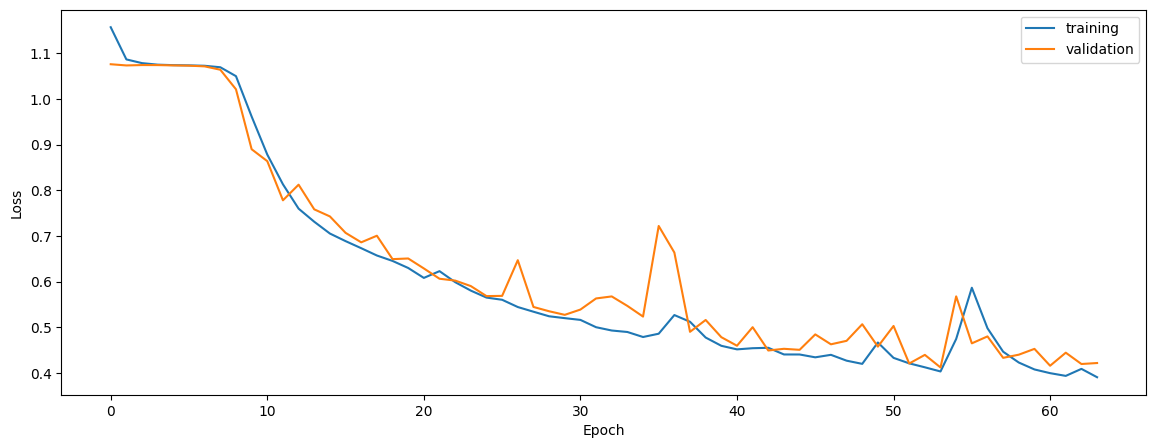

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.8405744181997825


0.833055935134155


0.8213392174577803


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.8685057621170444


0.8440543485663693


0.8292941637650748


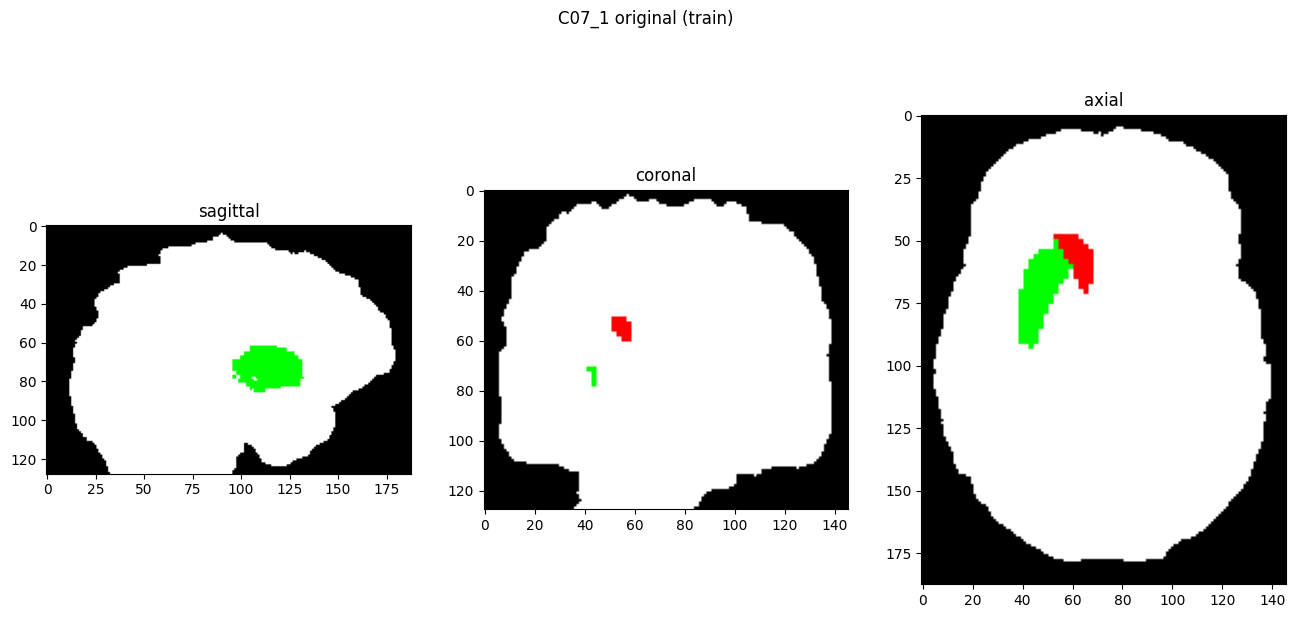

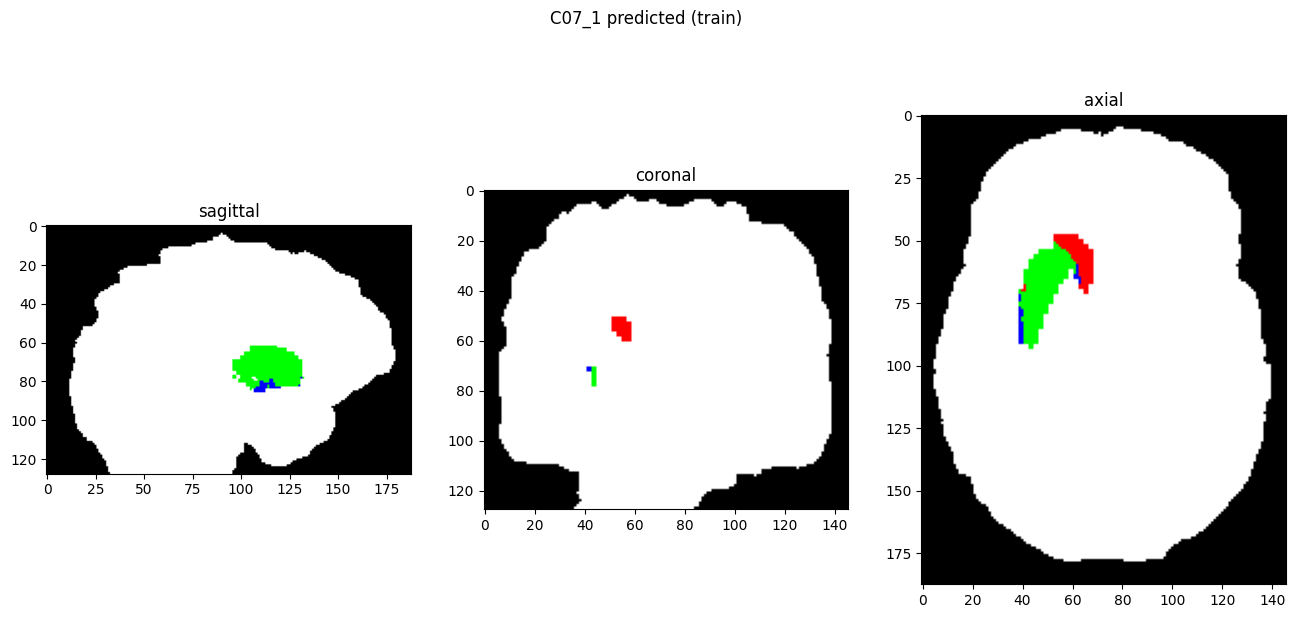

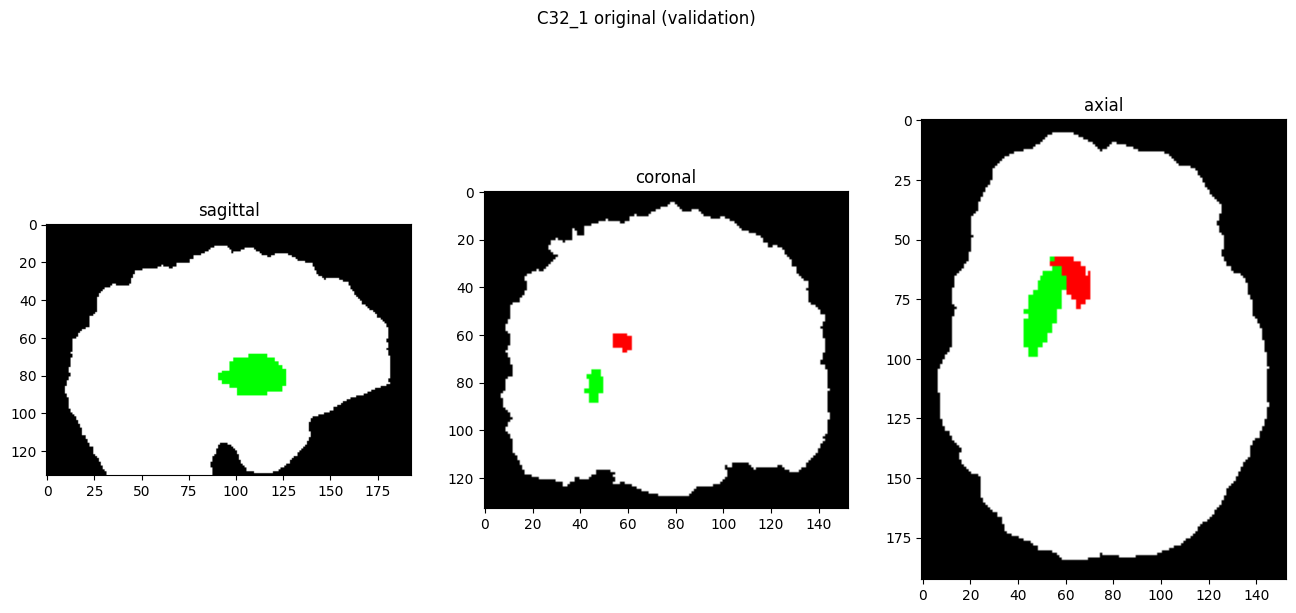

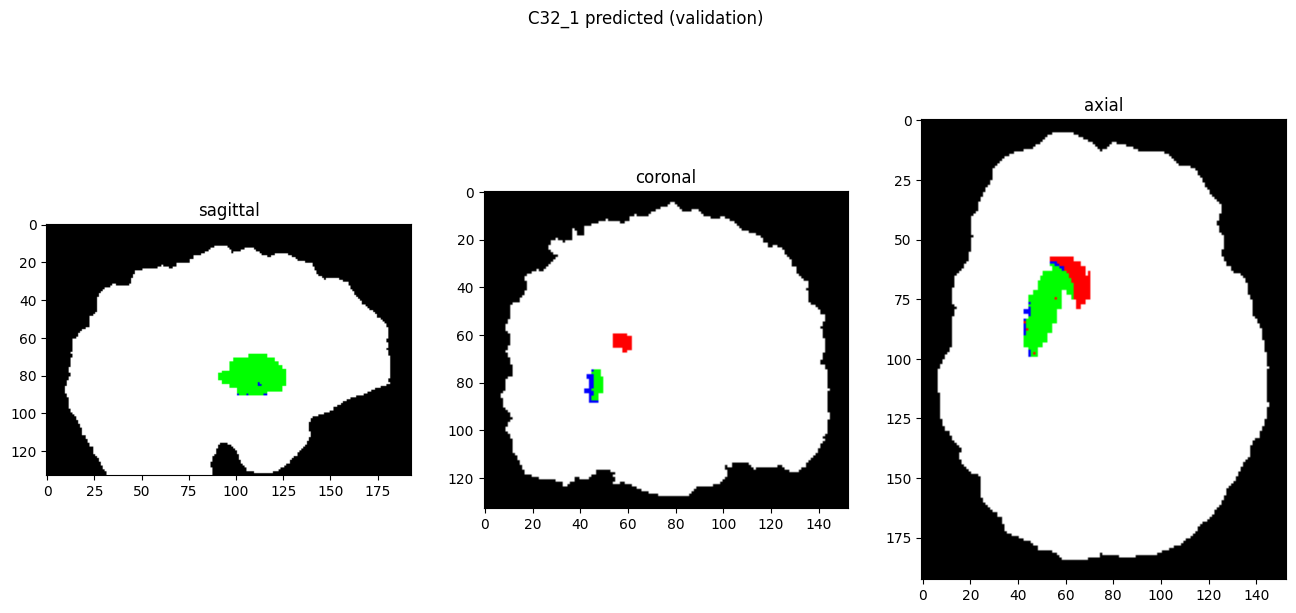

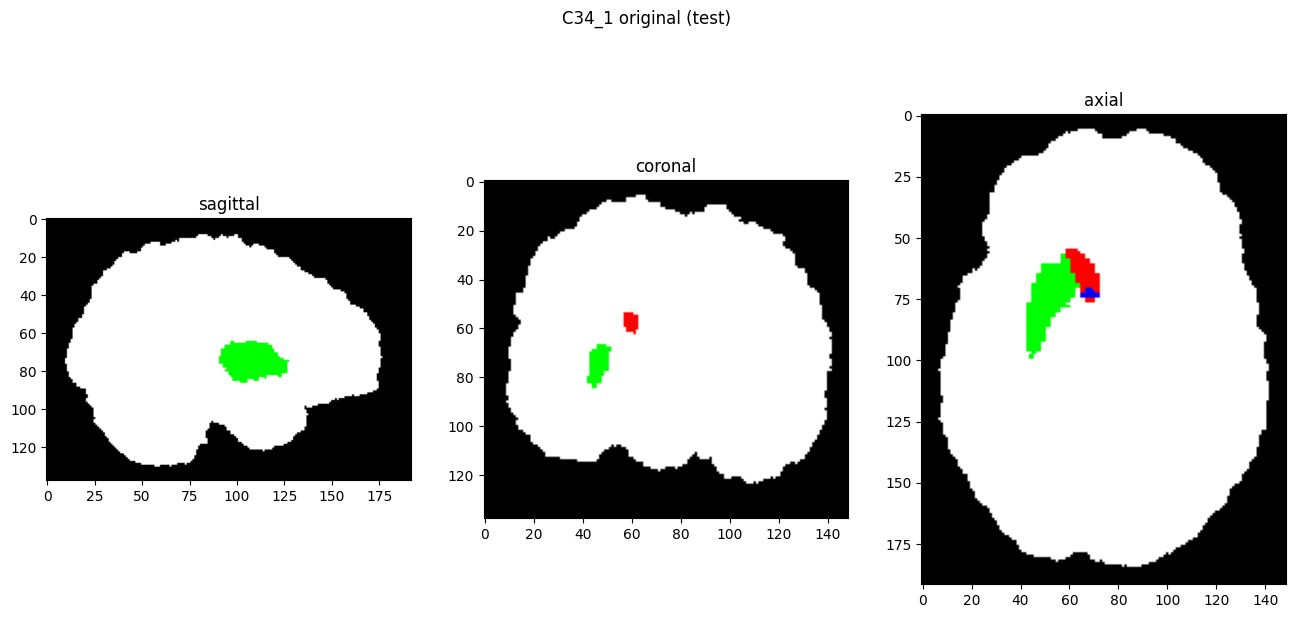

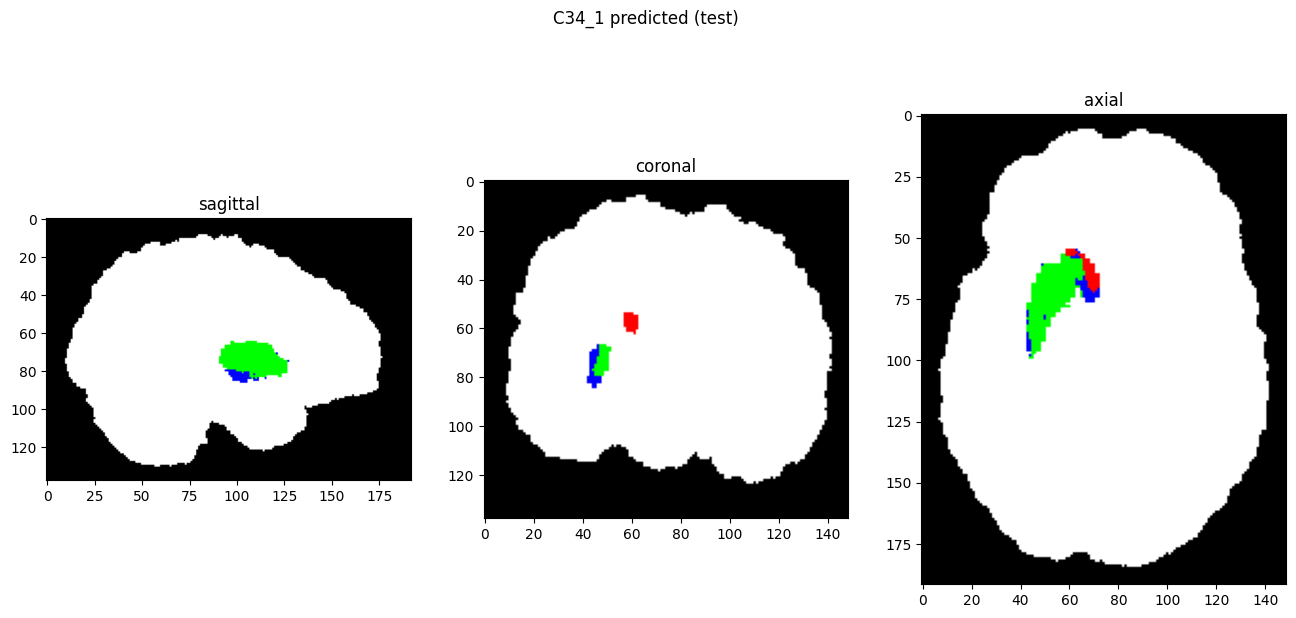

In [9]:
showResults(model, gen, threshold=0)